In [1]:
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from skimage.segmentation import clear_border
import pylab

In [2]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
from collections import Counter

In [3]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, Convolution2D, MaxPooling3D, MaxPooling2D
from keras import layers
from keras import Model
from keras.optimizers import *
from keras.utils import np_utils
from keras import backend as K
from keras.models import Sequential
from keras import models
from keras import optimizers
from keras.callbacks import TensorBoard
import keras.losses
import keras.metrics
from keras.models import load_model

Using TensorFlow backend.


### Fonctions

In [4]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [5]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

In [6]:
def get_segmented_lungs(im):
    
    '''
    Segmente le poumon pour une slice 2D, cf le notebook pre_processing
    '''
    

    
    #Step 1: Convertion en image binaire, seuil de 604
    
    binary = im < 604
    
    #Step 2: Enleve les bords de l'image pour garder que le contenu
    
    cleared = clear_border(binary)
  
    #Step 3: On labelise l image, cette operation permet de scinder une image binaire en differente zone, selon les contacts entre les pixels

    label_image = label(cleared)

    
    #Une fois la labelisation faite, on va garder les deux regions les plus grandes, correspondants ainsi aux deux poumons
    
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0

    #Step 4: Erosion pour separer les contacts avec les vaisseaux sanguins
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    
    #Step 5: Closure, pour garder les nodules attachees aux parois des poumons
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    #Step 6: Remplissage
    
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    
    #Step 7: Application du masque a l image d entree
    
    get_high_vals = binary == 0
    im[get_high_vals] = 0

    return im

In [7]:
def segment_lung_from_ct_scan(ct_scan):
	return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])


In [8]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        
                        mask_x = int(max(0,min(image_mask.shape[0]-1,coords[0])))
                        mask_y = int(max(0,min(image_mask.shape[1]-1,coords[1])))
                        mask_z = int(max(0,min(image_mask.shape[2]-1,coords[2])))

                        image_mask[mask_x,mask_y,mask_z] = int(1)

    return image_mask

In [9]:
'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands, imageName,path):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    #np.save(path + imageName + '_lung_img.npz', lung_img_512)
    #np.save(path + imageName + '_lung_mask.npz', lung_mask_512)
    #np.save(path + imageName + '_nodule_mask.npz', nodule_mask_512)
    
    #return
    return lung_img_512,nodule_mask_512

### Pre_processing

In [10]:
INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0'
cands = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/annotations.csv')

processed_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/'
slice_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices'

patients_short = os.listdir(INPUT_FOLDER)

images = os.listdir(INPUT_FOLDER)
images_path = [os.path.join(INPUT_FOLDER,patient) for patient in patients_short]

##On ne garde que les images en .mhd
images_mhd = []

for i in range(0,len(images)):
    if images[i][-4:] == '.mhd':
        images_mhd.append(images[i])

images_mhd_path = [os.path.join(INPUT_FOLDER,mhd) for mhd in images_mhd]

##Liste des cands pour chaque image, on depasse un peu mais rien de grave
cands_list = []
for i in range(0,len(images_mhd)):
    cands_list.append(cands[cands['seriesuid'] == images_mhd[i][0:-4]])

In [11]:
numero = 16
mhd_path = images_mhd_path[numero]
im_mhd = images_mhd[numero]
lung,nodule = create_nodule_mask(mhd_path, cands_list[numero], im_mhd[0:-4],processed_folder)

In [12]:
for i in range(nodule.shape[0]):
    if (np.sum(nodule[i,:,:]) > 0):
        print(i)

246
247
248
249
250
251
252
253
254
255


On plot l'image et le masque associé
Notons que pour la suite, le zero padding ne sera pas fait avec des 0 mais des -1024 pour ne pas avoir de discontinuité dans l'image, sans quoi la segmentation est inefficace (si ce n'est impossible)

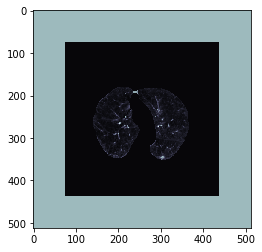

In [13]:
plt.imshow(lung[250],cmap=pylab.cm.bone)

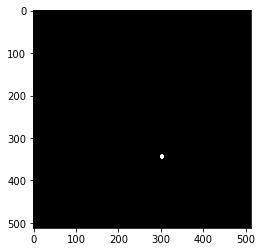

In [14]:
plt.imshow(nodule[250],cmap=pylab.cm.bone)

Pour feed l'UNET, on mettra en forme les données grâce au script luna16_generates.py. Les données générées par ce script sont des tranches contenant des nodules, qui seront alors feed au réseau de neuronne

### UNET

In [15]:
'''
Modification du DataGenerator pour pouvoir gerer notre type de donnees
'''

class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, dim_x = 512, dim_y = 512, dim_z = 1, batch_size = 32, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def generate(self,list_IDs,INPUT_FOLDER):
        #'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)
            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X, Y = self.__data_generation(list_IDs_temp,INPUT_FOLDER)

                yield X, Y
                    
    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self,list_IDs_temp,INPUT_FOLDER):
        #'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        Y = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        # Generate data

        for i, ID in enumerate(list_IDs_temp):
            # Store volume
            X[i, :, :, 0] = np.load(INPUT_FOLDER + '/' + ID + '_lung_img.npz.npy')
            # Store class
            Y[i,:,:,0] = np.load(INPUT_FOLDER + '/' + ID + '_nodule_mask.npz.npy')
        return X, Y

In [16]:
def unet():
	inputs = Input((512,512,1))

	conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
	conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
	pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

	conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
	conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

	conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)

	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


	conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
	conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
	drop4 = Dropout(0.5)(conv4)
	pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

	conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
	conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
	drop5 = Dropout(0.5)(conv5)

	up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
	merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
	conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
	conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

	up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
	merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
	conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
	conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

	up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
	merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
	conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
	conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

	up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
	merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
	conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
	conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
	conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
	conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

	model = Model(input = inputs, output = conv10)

	model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

	model.summary()

	return model

In [17]:
def generate_unique_logpath(logdir, raw_run_name):
        i = 0
        while(True):
                run_name = raw_run_name + "-" + str(i)
                log_path = os.path.join(logdir, run_name)
                if not os.path.isdir(log_path):
                        return log_path
                i = i + 1

In [18]:
# Pour la segmentation, on a besoin d utiliser le coefficient de dice comme fonction de precision
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [19]:
#La perte est juste l oppose du coefficient de dice (permet de decroitre)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [22]:
def generate_list_ID(folder):
	np_list = os.listdir(folder)
	list_IDs = []
	for i,name in enumerate(np_list):
		if name[-16:-8] == "lung_img":
			list_IDs.append(name[0:-17])
	return list_IDs

In [20]:
model=unet()

/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:37: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Us

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

__Juste un copie-colle du code présent dans LUNA16_UNET.py, n'a pas vocation à être run car trop long, et nécessite la bonne mise en force__

In [ ]:
TRAIN_FOLDER = '/home/lucsoret/Projet/CEI/Data/LUNA16/Images/processed/TRAIN'
VAL_FOLDER = '/home/lucsoret/Projet/CEI/Data/LUNA16/Images/processed/VAL'


list_IDs_TRAIN = generate_list_ID(TRAIN_FOLDER)
list_IDs_VAL = generate_list_ID(VAL_FOLDER)

#Tensorboard
run_name = "UNET"
logpath = generate_unique_logpath("'/home/lucsoret/Projet/CEI/Data/LUNA16/UNET/logs_linear", run_name)
tbcb = TensorBoard(log_dir=logpath)

# Parameters
params = {'dim_x': 512,
          'dim_y': 512,
          'dim_z': 1,
          'batch_size': 4,
          'shuffle': True}

training_generator = DataGenerator(**params).generate(list_IDs_TRAIN,TRAIN_FOLDER)
validation_generator = DataGenerator(**params).generate(list_IDs_VAL,VAL_FOLDER)

#Charge des poids deja definis, juste mettre model = unet() sinon
keras.losses.dice_coef_loss = dice_coef_loss
keras.metrics.dice_coef = dice_coef
model_path_init = '/home/lucsoret/Projet/CEI/Data/LUNA16/UNET/h5/UNET-0'
model = load_model(model_path_init)
#model = unet()

history = model.fit_generator(generator = training_generator,
                    steps_per_epoch = 20,
                    epochs = 10,
                    validation_data = validation_generator,
                    validation_steps = 20,
                    callbacks=[tbcb])
model_path = generate_unique_logpath('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/UNET/h5',run_name)
model.save(model_path)

### UNET-VERIFICATION

In [25]:
import keras.losses
import keras.metrics
from keras.models import load_model

In [26]:
h5_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/UNET/h5'
keras.losses.dice_coef_loss = dice_coef_loss
keras.metrics.dice_coef = dice_coef
model_path_init = os.path.join(h5_folder,'UNET-0')
model = load_model(model_path_init)

/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


__Tester avec une image test et une image train__

In [27]:
params = {'dim_x': 512,
	          'dim_y': 512,
	          'dim_z': 1,
	          'batch_size': 1,
	          'shuffle': False}
SUBSET_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/TEST'
list_IDs_subset = generate_list_ID(SUBSET_FOLDER)
subset_generator = DataGenerator(**params).generate(list_IDs_subset,SUBSET_FOLDER)

In [28]:
numero = 325
lung_to_predict = np.empty((1,512,512,1))
lung_to_predict[0,:,:,0] = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_lung_img.npz.npy'))
predict_subset = model.predict(lung_to_predict)
mask_predict = predict_subset[0,:,:,0]

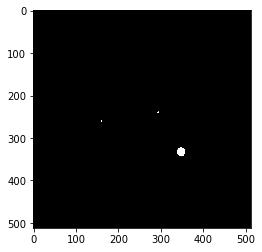

In [29]:
plt.imshow(mask_predict,cmap=pylab.cm.bone)

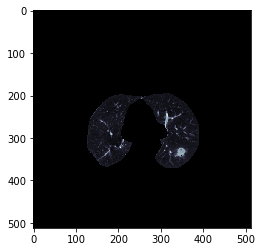

In [30]:
plt.imshow(lung_to_predict[0,:,:,0],cmap=pylab.cm.bone)

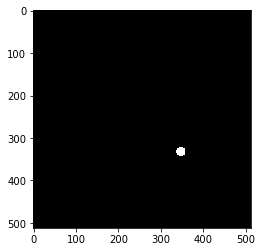

In [31]:
mask_real = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_nodule_mask.npz.npy'))
plt.imshow(mask_real,cmap=pylab.cm.bone)

In [ ]:
#mask_real_full = np.empty((1,512,512,1))
#mask_real_full[0,:,:,0] = mask_real
#evaluate = model.evaluate(lung_to_predict,mask_real_full,batch_size=1)

In [ ]:
#evaluate[1]

#### Evaluate avec seuil et de la bonne volontée

In [32]:
'''
L'output du réseau de neurones n'est pas binaire, on applique donc un seuil pour avoir un réel masque binaire,
ce qui est plus pertinent pour évaluer la qualité des résultats
'''

def seuil_mask_pred(mask_predict):
    for i in range(0, mask_predict.shape[0]):
        for j in range(0, mask_predict.shape[1]):
            if(mask_predict[i][j] < 0.1 or i > 500 or j >500):
                mask_predict[i][j] = 0
            else:
                mask_predict[i][j] = 1
    return(mask_predict)

In [33]:
def homemade_precision(y_true_f,y_pred_f):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(y_true_f)):
        if (y_pred_f[i] == 1 and y_true_f[i] ==1):
            TP += 1
        elif (y_pred_f[i] == 0 and y_true_f[i] ==1):
            FN += 1
        elif (y_pred_f[i] == 1 and y_true_f[i] ==0):
            FN += 0
    return(TP,FP,FN)

In [34]:
def calcul_precision(FOLDER):
    precision_list = []
    list_IDs_subset = generate_list_ID(FOLDER)
    for i,ID in enumerate(list_IDs_subset):
        mask_real = np.load(os.path.join(FOLDER,ID +'_nodule_mask.npz.npy'))
   
        lung_to_predict = np.empty((1,512,512,1))
        lung_to_predict[0,:,:,0] = np.load(os.path.join(FOLDER,ID+'_lung_img.npz.npy'))
        predict_subset = model.predict(lung_to_predict)
        mask_predict = predict_subset[0,:,:,0]
        
        mask_predict_seuil = seuil_mask_pred(mask_predict)
        
        y_true_f = mask_real.flatten()
        y_pred_f = mask_predict_seuil.flatten()
        TP,FP,FN = homemade_precision(y_true_f,y_pred_f)
        precision = float(TP)/float(FP+FN+TP)
        
        precision_list.append(precision)
        print(i)
        print(precision)
    return precision_list
        

In [ ]:
#C'est un peu long.., pas très utile de tout exectuer

TEST_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/TEST'
calcul_precision(TEST_FOLDER)

In [36]:
TEST_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/TEST'
list_IDs_subset = generate_list_ID(TEST_FOLDER)
numero = 30
lung_to_predict = np.empty((1,512,512,1))
lung_to_predict[0,:,:,0] = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_lung_img.npz.npy'))
mask_real = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_nodule_mask.npz.npy'))
predict_subset = model.predict(lung_to_predict)
mask_predict = predict_subset[0,:,:,0]

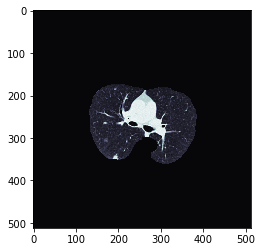

In [37]:
plt.imshow(lung_to_predict[0,:,:,0],cmap=pylab.cm.bone)

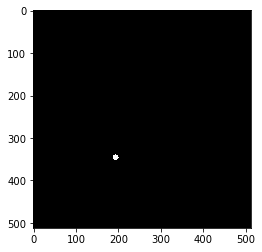

In [38]:
plt.imshow(mask_real,cmap=pylab.cm.bone)

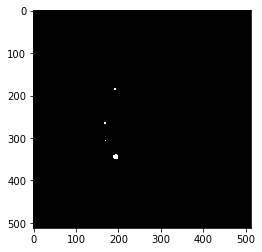

In [39]:
plt.imshow(mask_predict,cmap=pylab.cm.bone)

###### Evaluation de la precision

In [40]:
'''
Precision generee par le script : luna16_precision.py, compter plusieurs heures d'execution
'''

path ='/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/UNET/precision'
name = os.listdir(path)
precision_full = np.load(os.path.join(path,name[0]))
precision_partielle_mean = np.load(os.path.join(path,name[1]))
precision_mean = np.load(os.path.join(path,name[2]))

In [41]:
precision_full.sort()
Counter(precision_full)[0]
print("Nombre de 0 sur longueur")
print(float(Counter(precision_full)[0])/float(len(precision_full)))
print("Precision_mean")
print(precision_mean)
print("Precision_partielle_mean")
print(precision_partielle_mean)

Nombre de 0 sur longueur
0.427172582619
Precision_mean
0.410083698365
Precision_partielle_mean
0.715893977701
